# 11wk-1: 순환신경망 (4)

최규빈  
2022-11-10

> RNN (2)– AbAcAd예제(3)

# 강의영상

> <https://youtube.com/playlist?list=PLQqh36zP38-zRWSBjuvzsjPe6JxnHO4AX>

# import

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define some funtions

In [2]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 
soft = torch.nn.Softmax(dim=1)

# Exam4: AbAcAd (3)

## data

`-` 기존의 정리방식

In [3]:
txt = list('AbAcAd')*100
txt[:10]

In [4]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [5]:
txt_x[:5],txt_y[:5]

In [6]:
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,{'A':0,'b':1,'c':2,'d':3}))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,{'A':0,'b':1,'c':2,'d':3}))).float()

In [7]:
x,y

## 순환신경망 구현2 (with RNNCell, hidden node 2)

ref: <https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html>

`(1)` 숙성네트워크

In [8]:
torch.manual_seed(43052)
rnncell = torch.nn.RNNCell(4,2) # x:(n,4) h:(n,2) 

`(2)` 조리네트워크

In [9]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) # 숙성된 2차원의 단어를 다시 4차원으로 바꿔줘야지 나중에 softmax취할 수 있음

`(3)` 손실함수와 옵티마이저

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()))

`(4)` 학습

In [11]:
T = len(x) 
for epoc in range(5000):
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2) 
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = rnncell(xt,ht)
        ot = cook(ht)
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화

In [12]:
hidden = torch.zeros(T,2) 

In [13]:
# t=0 
_water = torch.zeros(1,2)
hidden[[0]] = rnncell(x[[0]],_water)
# t=1~T 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])

In [14]:
yhat = soft(cook(hidden))
yhat

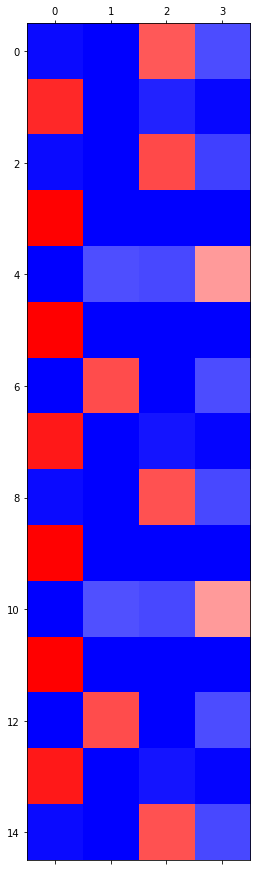

In [15]:
plt.matshow(yhat[:15].data,cmap='bwr')

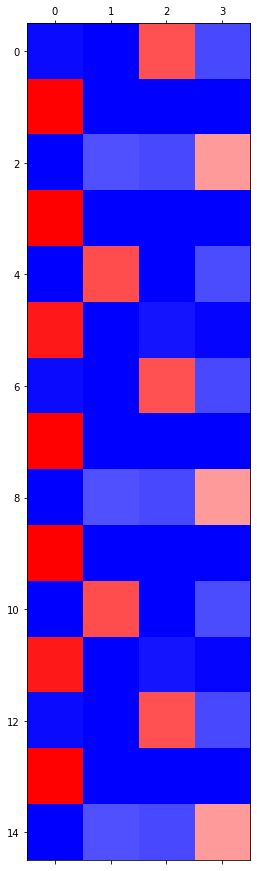

In [16]:
plt.matshow(yhat[-15:].data,cmap='bwr')

## 순환신경망 구현3 (with RNN, hidden node 2) – 성공

(예비학습)

`-` 네트워크학습이후 yhat을 구하려면 번거로웠음

``` python
hidden = torch.zeros(T,2) 
_water = torch.zeros(1,2)
hidden[[0]] = rnncell(x[[0]],_water)
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])
yhat = soft(cook(hidden))
```

`-` 이렇게 하면 쉽게(?) 구할 수 있음

In [17]:
rnn = torch.nn.RNN(4,2)

In [18]:
rnn.weight_hh_l0.data = rnncell.weight_hh.data 
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data

`-` rnn(x,\_water)의 결과는 (1) 599년치 간장 (2) 599번째 간장 이다

In [19]:
rnn(x,_water), hidden

In [20]:
soft(cook(rnn(x,_water)[0]))

***(예비학습결론) torch.nn.RNN(4,2)는 torch.nn.RNNCell(4,2)의 batch
버전이다. (for문이 포함된 버전이다)***

------------------------------------------------------------------------

torch.nn.RNN(4,2)를 이용하여 구현하자.

`(1)` 숙성네트워크

선언

In [21]:
rnn = torch.nn.RNN(4,2)

가중치초기화

In [22]:
torch.manual_seed(43052)
_rnncell = torch.nn.RNNCell(4,2)

In [23]:
rnn.weight_hh_l0.data = _rnncell.weight_hh.data 
rnn.weight_ih_l0.data = _rnncell.weight_ih.data
rnn.bias_hh_l0.data = _rnncell.bias_hh.data
rnn.bias_ih_l0.data = _rnncell.bias_ih.data

`(2)` 조리네트워크

In [24]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) 

`(3)` 손실함수와 옵티마이저

In [25]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()))

`(4)` 학습

In [26]:
_water = torch.zeros(1,2) 
for epoc in range(5000):
    ## 1 
    hidden,hT = rnn(x,_water)
    output = cook(hidden) 
    ## 2 
    loss = loss_fn(output,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화1: yhat

In [27]:
yhat = soft(output)

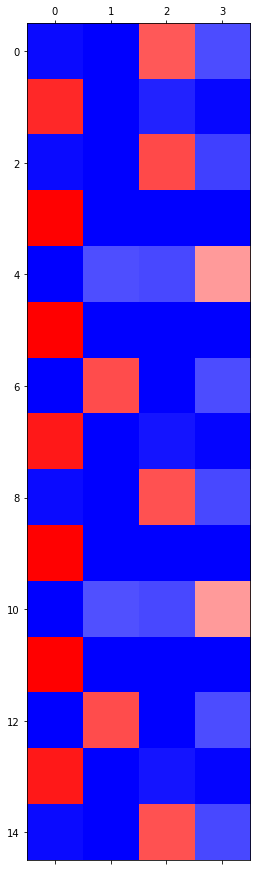

In [28]:
plt.matshow(yhat.data[:15],cmap='bwr')

-   처음은 좀 틀렸음 ㅎㅎ

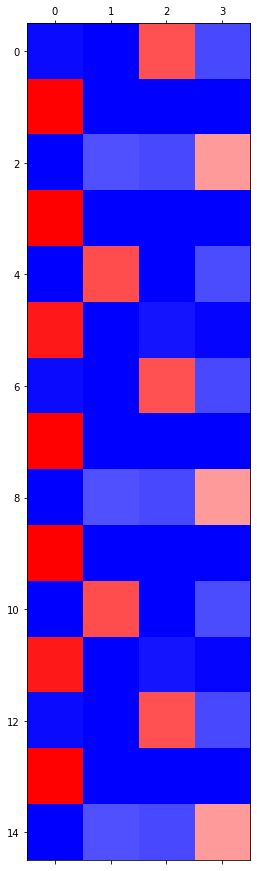

In [29]:
plt.matshow(yhat.data[-15:],cmap='bwr')

-   뒤에는 잘맞음

**실전팁: `_water` 대신에 `hT`를 대입 (사실 큰 차이는 없음)**

In [30]:
rnn(x[:6],_water),rnn(x[:6],hT)

`(6)` 시각화2: hidden, yhat

In [31]:
combinded = torch.concat([hidden,yhat],axis=1)

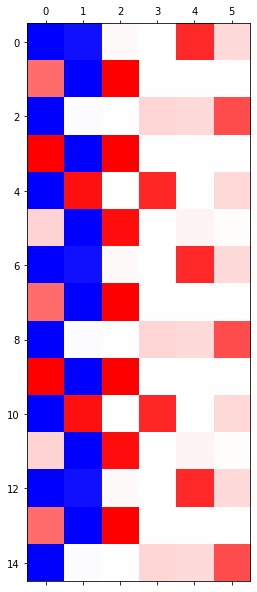

In [32]:
plt.matshow(combinded[-15:].data,cmap='bwr')

-   히든노드의 해석이 어려움.

## 순환신경망 구현4 (with RNN, hidden node 3) – 성공

`(1)` 숙성네트워크~ `(2)` 조리네트워크

In [33]:
torch.manual_seed(2) #1 
rnn = torch.nn.RNN(4,3) 
cook = torch.nn.Linear(3,4) 

`(3)` 손실함수와 옵티마이저

In [34]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()))

`(4)` 학습

In [35]:
_water = torch.zeros(1,3) 
for epoc in range(5000):
    ## 1
    hidden,hT = rnn(x,_water) 
    output = cook(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화1: yhat

In [36]:
yhat = soft(output)

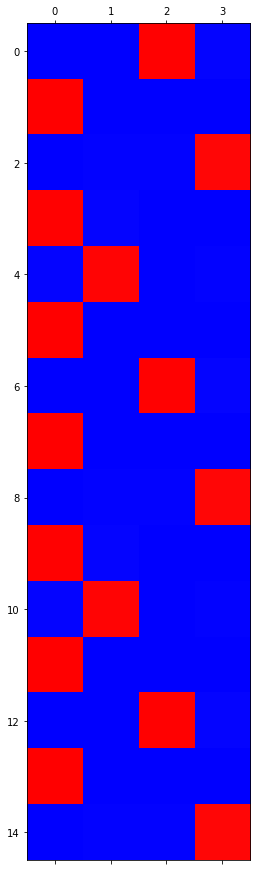

In [37]:
plt.matshow(yhat[-15:].data,cmap='bwr')

`(6)` 시각화2: hidden, yhat

In [38]:
combinded = torch.concat([hidden,yhat],axis=1)

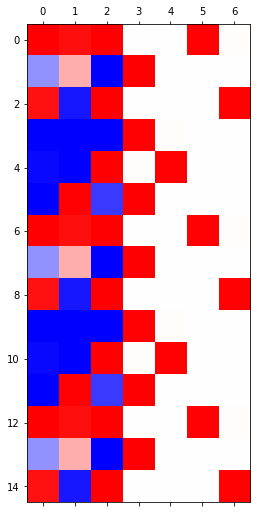

In [39]:
plt.matshow(combinded[-15:].data,cmap='bwr')

-   세번째 히든노드 = 대소문자를 구분
-   1,2 히든노드 = bcd를 구분

# HW: hello 예제

아래와 같이 hello가 반복되는 자료가 있다고 하자.

In [40]:
txt = list('hello')*100
txt[:10]

In [41]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [42]:
txt_x[:5],txt_y[:5]

In [43]:
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,{'h':0,'e':1,'l':2,'o':3}))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,{'h':0,'e':1,'l':2,'o':3}))).float()

In [44]:
x,y

3개의 은닉노드를 가진 RNN을 설계하고 학습시켜라.